# CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

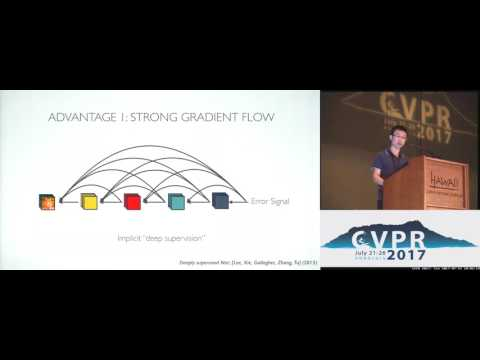

In [1]:
#https://arxiv.org/pdf/1608.06993.pdf

from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=700)

In [2]:
from datetime import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import tensorflow
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Load CIFAR10 Data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f'Shape of train data : {x_train.shape}')
print(f'Shape of test data  : {x_test.shape}')

170498071/170498071 [==============================] - 3s 0us/step
Shape of train data : (50000, 32, 32, 3)
Shape of test data  : (10000, 32, 32, 3)


In [4]:
img_height, img_width, channel_count = x_train.shape[1], x_train.shape[2], x_train.shape[3]

In [5]:
Epochs = 300
Num_classes = 10
Batch_size = 128

In [6]:
# Convert class vector to binary class matrix

print(f'Shape of class vector BEFORE converting into BINARY class matrix : {y_train.shape}')

y_train = to_categorical(y_train, Num_classes)
y_test = to_categorical(y_test, Num_classes)

print(f'Shape of class vector AFTER converting into BINARY class matrix  : {y_train.shape}')

Shape of class vector BEFORE converting into BINARY class matrix : (50000, 1)
Shape of class vector AFTER converting into BINARY class matrix  : (50000, 10)


### Image Augmentation

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 10, shear_range = 0.4, zoom_range = 0.3,
                             horizontal_flip = True, vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)

### Bottleneck Layer :
<img src = 'https://i.imgur.com/I1wW0ae.jpg'>

Ref : https://youtu.be/-W6y8xnd--U

> *BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)*

In [8]:
def bottleneck(input_, num_filter = 12, loop = 16):
    
    temp = input_
    for _ in range(loop):
        
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_1_1 = Conv2D(4 * num_filter, (1, 1), use_bias = False, padding = 'same')(relu)

        BatchNorm = BatchNormalization()(Conv2D_1_1)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(num_filter, (3, 3), use_bias = False, padding = 'same')(relu)
        
        concat = Concatenate(axis = -1)([temp, Conv2D_3_3])
        
        temp = concat
    
    return temp

### Translation Layer :
> *The transition layers used in our experiments consist of a batch normalization layer and an 1×1 convolutional layer followed by a 2×2 average pooling layer.*

In [9]:
def transition(input_, num_filter = 12, compression = 0.5):
    
    num_filter = input_.shape.as_list()[-1]
    BatchNorm = BatchNormalization()(input_)
    relu = Activation('relu')(BatchNorm)
    Conv2D_transition = Conv2D(int(num_filter * compression), (1, 1),
                               use_bias = False, padding = 'same')(relu)
    avg = AveragePooling2D(pool_size = (2, 2))(Conv2D_transition)
    
    return avg

### Output Layer :
> *At the end of the last dense block, a global average pooling is performed and then a softmax classifier is attached.*

In [10]:
def output_layer(input_, num_classes = 10):

    BatchNorm = BatchNormalization()(input_)
    GlobalAP = GlobalAveragePooling2D()(BatchNorm)
    outP = Dense(num_classes, activation = 'softmax')(GlobalAP)
    
    return outP

### Architecture

<img src = 'https://i.imgur.com/LOLri67.jpg'>

Ref : https://youtu.be/-W6y8xnd--U

**Experimenting with the basic DenseNet structure with configurations L = 100 and k = 12.**

    Where L : Layers
          k : Growth Rate
> *In our experiments on ImageNet, we use a DenseNet-BC structure with 4 dense blocks on 224×224 input images. The initial convolution layer comprises 2k convolutions of size 7×7 with stride 2*

In [11]:
tensorflow.keras.backend.clear_session()
tensorflow.random.set_seed(45)
np.random.seed(48)

num_filter = 12

in_ = Input(shape = (img_height, img_width, channel_count))
First_Conv2D = Conv2D(2 * num_filter, (3,3), use_bias=False ,padding='same')(in_)

First_Block = bottleneck(First_Conv2D)
First_Transition = transition(First_Block)

Second_Block = bottleneck(First_Transition)
Second_Transition = transition(Second_Block)

Third_Block = bottleneck(Second_Transition)
Third_Transition = transition(Third_Block)


output = output_layer(Third_Transition)

In [12]:
tensorflow.keras.backend.clear_session()

model = Model(inputs=[in_], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 24)   648         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 24)   0           ['batch_normalization[0][0]']

In [13]:
# https://stackoverflow.com/a/59564740

class AccThreshold(Callback):
    
    def __init__(self, threshold):
        self.threshold = threshold + 0.01

    def on_epoch_end(self, epoch, logs = {}): 
        val_acc = logs.get('val_accuracy')
        if val_acc >= self.threshold:
            print(f'\n\n\tTerminating training at epoch {epoch+1} with a \
            minimum validation accuracy of {self.threshold} %\n')
            self.model.stop_training = True

In [14]:
logdir = 'logs/' + datetime.now().strftime('%Y%m%d_%H%M%S')
tensorBoard = TensorBoard(log_dir = logdir, histogram_freq = 1)

filepath = 'modelCheck/epo_{epoch:02d}-accu_{val_accuracy:.4f}.hdf5'
checkPoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 0)

reduceLr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 2, verbose = 1)

my_callback = AccThreshold(threshold = 0.9)

callBack_List = [tensorBoard, checkPoint, reduceLr, my_callback]

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(x_test)

In [16]:
sgd = SGD(learning_rate = 0.1, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
!nvidia-smi

Fri Aug 19 06:59:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   29C    P0    58W / 300W |  20933MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
steps = len(x_train) // Batch_size
val_steps = len(x_test)//Batch_size

mod = model.fit(datagen.flow(x_train, y_train, batch_size = Batch_size), epochs = Epochs, verbose = 1,
                validation_data = test_datagen.flow(x_test, y_test, batch_size = Batch_size),
                steps_per_epoch = steps, validation_steps = val_steps, callbacks = callBack_List)

Epoch 1/300
390/390 [==============================] - 96s 220ms/step - loss: 1.4434 - accuracy: 0.4786 - val_loss: 1.8177 - val_accuracy: 0.3941 - lr: 0.0010
Epoch 2/300
390/390 [==============================] - 84s 216ms/step - loss: 0.9688 - accuracy: 0.6559 - val_loss: 1.1896 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 3/300
390/390 [==============================] - 84s 216ms/step - loss: 0.7614 - accuracy: 0.7346 - val_loss: 1.0901 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 4/300
390/390 [==============================] - 85s 217ms/step - loss: 0.6459 - accuracy: 0.7757 - val_loss: 0.9804 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 5/300
390/390 [==============================] - 84s 216ms/step - loss: 0.5762 - accuracy: 0.8006 - val_loss: 0.7682 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 6/300
390/390 [==============================] - 84s 216ms/step - loss: 0.5205 - accuracy: 0.8182 - val_loss: 0.8841 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 7/300
390/390 [=========================

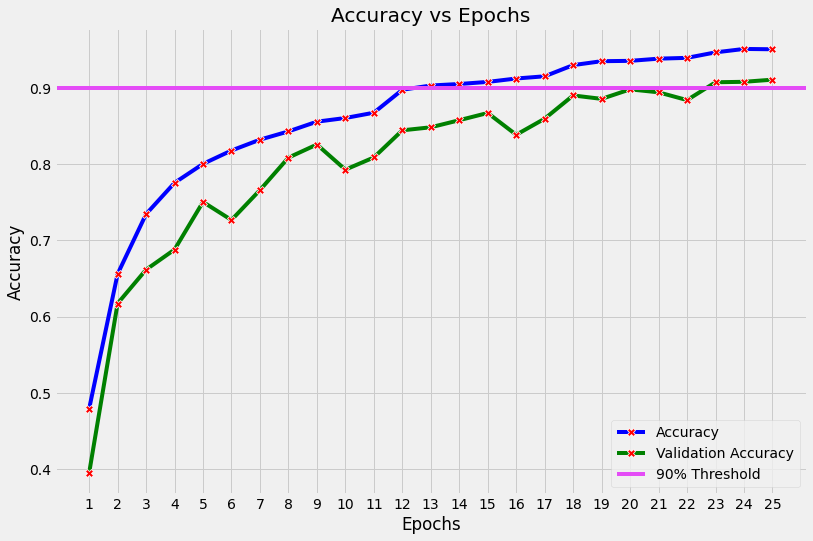

In [19]:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html

epochs_ = list(range(1, len(mod.history['accuracy']) + 1))

plt.figure(figsize = (12, 8))
sns.lineplot(y = 'accuracy', data = mod.history , x = epochs_,
             label = 'Accuracy', color = 'b', marker = 'X', mfc = 'red', ms = 8)
sns.lineplot(y = 'val_accuracy', data = mod.history , x = epochs_,
             label = 'Validation Accuracy', color = 'g', marker = 'X', mfc = 'red', ms = 8)
plt.axhline(0.9, color = '#E44CF6', label = '90% Threshold')
plt.title('Accuracy vs Epochs')
plt.legend(loc = 4) ; plt.xticks(epochs_)
plt.xlabel('Epochs') ; plt.ylabel('Accuracy')
plt.show()

<br><br><br>
### TensorBoard

<img src = 'https://i.imgur.com/8tOa0dw.jpg'>
<br><br><br>

<img src = 'https://i.imgur.com/15OfS1M.jpg'>
<br><br><br>

<img src = 'https://i.imgur.com/ZSxzKT5.png'>